<a href="https://colab.research.google.com/github/RJuro/UMA-NLP2019/blob/master/introNLP_CDMX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spanish_sentiment_analysis
!pip install langid
!pip install umap-learn


     |████████████████████████████████| 15.8MB 2.9MB/s 
     |████████████████████████████████| 276kB 43.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141aaff1f9df810905a13fc75d57
Successfully built marisa-trie
     |████████████████████████████████| 1.9MB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/29/bc/61/50a93be85d1afe9436c3dc61f38da8ad7b637a38af4824e86e
Successfully built langid


# Introduction to Natural Language Processing & Machine Learning for Social Science Research

### Roman Jurowetzki, Assistant Professor, Aalborg University Denmark
### 8/7 - 2019 UAM, CDMX

- In this tutorial we will explore some relatively approachible techniques to utilize text as valuable data source in social science research. 
- The tutorial will use Python and several modern NLP and Machine Learning libraries to appraoch the problems
- I will present 3 cases of typical applications that can be transferred to different reserach contexts.
- We will be using a Jupyter Notebook as instruction and programming interface
- The material will be available at http://github.com/RJuro/UAM2019 and you should be able to replicate everything that we do today

## Case 1: AirBnb in CDMX

AirBnb is collecting large amounts of text data every time the platform asks hosts and guests to review each other. This information is essential to create trust and to allow transactions on the platform. 

The textual data is valuable as it countatins lots of information. We can for example ask:

- why did some one like or dislike a place?
- do people describe cheaper stays differently than those that are expensive?

We will use data form [InsideAirbnb](http://insideairbnb.com/ "Airbnb"), an independant platform that tracks Airbnb's influence on urban communities 

We will be using some out-of-the-box modules rather than train our classifiers from the ground up.

In [0]:
# import the pandas library for handling CSVs and table-type data 
# import numpy for some (simple) linear algebra
import pandas as pd
import numpy as np

In [17]:
# download and unzip the data that we are going to use
!wget https://storage.googleapis.com/roman-general/data.zip

--2019-07-08 19:17:53--  https://storage.googleapis.com/roman-general/data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61163094 (58M) [application/zip]
Saving to: ‘data.zip.2’

data.zip.2          100%[===================>]  58.33M  68.7MB/s    in 0.8s    

2019-07-08 19:17:55 (68.7 MB/s) - ‘data.zip.2’ saved [61163094/61163094]



In [18]:
!unzip data.zip

Archive:  data.zip.2
   creating: data/
  inflating: data/upwork_aom_300k.csv  
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._upwork_aom_300k.csv  
  inflating: data/reviews.csv        
  inflating: __MACOSX/data/._reviews.csv  
  inflating: data/spanish_revs.csv   
  inflating: __MACOSX/data/._spanish_revs.csv  
  inflating: data/listings.csv       
  inflating: __MACOSX/data/._listings.csv  


In [19]:
# Open the reviews and reduce from 300k to random 10k rows

reviews = pd.read_csv('reviews.csv')
reviews = reviews.sample(5000)

FileNotFoundError: ignored

In [0]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
327161,27110325,439306139,2019-04-18,132183399,Scarlett,Tiene todo lo que necesitas para un quick stay...
182915,17384083,185073007,2017-08-20,24339744,Guadalupe,La casa de Malena y Gustavo es bastante cómoda...
20812,2297850,146370376,2017-04-22,125154616,Marianela,"Francisco fue un host extraordinario,el aparta..."
37959,4951061,127204394,2017-01-16,12392101,Daniele,Arturo's place is a quiet set of apartments se...
131012,14150077,108599432,2016-10-16,75078637,Leopoldo,Good place near terminal 1 in MEX. Very quiet.


#### Language detection
First we need to detect the language of the review, as we will only focus on the Spanish reviews

The `langid` library is a good choice. It's easy to use and fast

In [0]:
# import the library

import langid

Text data is messy: Sometimes people just add 😉 or somewhint completely different. This is where the model gets into trouble and returns errors.
To prevent that form happening, we will write a little function that turns exceptions into "exp"


In [0]:
#defining a little exception-handling function for the language detector

def detect_lang(text):
    try: 
        return langid.classify(text)[0]
    except Exception:
        return 'exp'

In [0]:
# we apply the language detection function
reviews['lang'] = reviews['comments'].apply(detect_lang)

In [0]:
# now, we filter out the spanish reviews
spanish_reviews = reviews[reviews['lang'] == 'es']

#### Sentiment analysis - easy version
In this part of the tutorial we will be using a pre-trained Spanish sentiment analysis model from https://github.com/aylliote/senti-py to figure out how people feel about their stays

In [0]:
# We import and instantiate the classifier

from classifier import *
clf = SentimentClassifier()

In [0]:
# Let's try it out
x = "Esta muy buena esa pelicula"

print(x + ' ==> %.5f' % clf.predict(x))

Esta muy buena esa pelicula ==> 0.93136


In [0]:

X = ["Son malaaaaa onda esos vecinossss", 'el BIFE estuvo EXCELENTE',
     '!!!! Quien te pensas que sos ??Ahora andate!!y no te quiero ver mas..!',
     'K askoooo']

for e in X:
    print(e + ' ==> %.5f' % clf.predict(e))

Son malaaaaa onda esos vecinossss ==> 0.22325
el BIFE estuvo EXCELENTE ==> 0.91101
!!!! Quien te pensas que sos ??Ahora andate!!y no te quiero ver mas..! ==> 0.08893
K askoooo ==> 0.01420


**speed issues**

Preprocessing of the text and prediction takes some time, unfortunately. These are, after all, heavy processes.  We will use simple multiprocessing (using all cores of the CPU) to optimize performance 

In [0]:
from multiprocessing import Pool

In [0]:
p = Pool()

In [0]:
%time spanish_reviews['score'] = p.map(clf.predict, spanish_reviews['comments'])

CPU times: user 26.4 s, sys: 1.62 s, total: 28 s
Wall time: 2min 5s


In [0]:
for i in spanish_reviews.sort_values('score', ascending=True)['comments'][:20]:
    print(i)
    print('\n')

I was contacted by the host through (Hidden by Airbnb) and asked what time I would arrive.  I advised her that we would get there around 545pm to 6pm.  Upon arrival a man was still mopping the floor. I couldn't even use the restroom because they were still cleaning.  I had to just leave my stuff and come back later. This should have been done before the 2pm checkin time, and definitely before 6pm.  The apartment and building was nice and historic with a good view from the room and roof.  However if don't like to be annoyed then I would look for another place.  The host contacted me too many times through (Hidden by Airbnb) .  The host should of contacted me through Airbnb, and asked first if I minded being contacted through (Hidden by Airbnb) .  The most irritating message was around 9m she asked me what time I would checkout.  This should matter if checkout is at 11am.  Then it all made sense when at (Phone number hidden by Airbnb) am a woman came and knocked on the door.  I told her 

#### Bringing in additional data for analysis
Now we can use additional information that we have on the houses to actually use our predictions

In [0]:
# we open the listings data
listings = pd.read_csv('listings.csv')

In [0]:
# We can calculate the median scores for all rooms
scores = pd.DataFrame(spanish_reviews.groupby('listing_id').median()['score'])

In [0]:
# We merge the listing data with our median reviews
merged = pd.merge(listings, scores, how='inner', left_on='id', right_on='listing_id')

In [0]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936 entries, 0 to 1935
Data columns (total 17 columns):
id                                1936 non-null int64
name                              1936 non-null object
host_id                           1936 non-null int64
host_name                         1934 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     1936 non-null object
latitude                          1936 non-null float64
longitude                         1936 non-null float64
room_type                         1936 non-null object
price                             1936 non-null int64
minimum_nights                    1936 non-null int64
number_of_reviews                 1936 non-null int64
last_review                       1936 non-null object
reviews_per_month                 1936 non-null float64
calculated_host_listings_count    1936 non-null int64
availability_365                  1936 non-null int64
score              

In [0]:
# Now we can for example explore median scores for the different parts of town

merged.groupby('neighbourhood').median()['score'].sort_values()

neighbourhood
Venustiano Carranza       0.923726
Iztapalapa                0.924480
Iztacalco                 0.929949
Xochimilco                0.935657
Tlalpan                   0.946728
Azcapotzalco              0.949425
Álvaro Obregón            0.953008
Miguel Hidalgo            0.953149
Gustavo A. Madero         0.958961
La Magdalena Contreras    0.961370
Cuauhtémoc                0.961513
Coyoacán                  0.961717
Benito Juárez             0.966209
Cuajimalpa de Morelos     0.975560
Tláhuac                   0.992623
Name: score, dtype: float64

## Case 2: Explaining text-predictions

Machine learning models are often considered "black-boxes". Especially more complex models (e.g. XGboost, SVMs, Neural Networks) don't let us directly see what they learn and how they make decisions.
In the past few years, the discussions on explainable AI have spurred lots of research in that area and today we have some ways to understand how machines decide (see this excellent book for details: https://christophm.github.io/interpretable-ml-book/)

In this short case, we will use the data from the previous example to train up a model (pretending that the estimated scores are the ground trougth)

Normally we would need human-labelled data but we pretend it's ok here.

In [0]:
# first, check the distribution of scores

%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

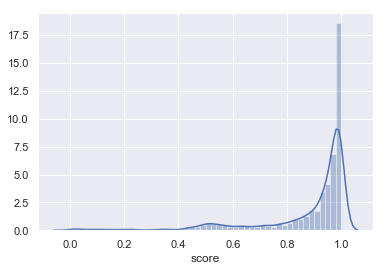

In [0]:
sns.distplot(spanish_reviews['score'])

In [0]:
# We can now say that everything over 0.2 is positive (which is a bad assumption...but ok)

spanish_reviews['positive'] = spanish_reviews['score'] >= 0.2

In [0]:
spanish_reviews[spanish_reviews['score'] <= 0.2]['comments']

131012       Good place near terminal 1 in MEX. Very quiet.
219408    Las fotos muestran el apartamento tal cual com...
63203     La ubicación y atención es excelente, consider...
185735                 Bonito depa con excelente ubicación!
250636    Muy limpio, super bien ubicado, zona muy tranq...
237683    Si tienes otras opciones, no te alojes aquí. L...
127896    Mi experiencia en general se ve plasmada en mi...
104612    Previo a mi llegada pude sentirme bienvenida. ...
76311     No me gusto, estaba sucio, no cuenta con todos...
94842     Lugar muy bien situado y marco es muy reactive...
191240    D (Phone number hidden by Airbnb) sss, excelen...
41212     Excelente depa como estar en casa. Excelente u...
296495    No pude haber encontrado un mejor alojamiento ...
283784    No me hospede ya que el lugar no era lo que es...
248065    El depto está muy descuidado y sucio, la alfom...
336126    No mames, este es el mejor lugar del mundo.\nO...
293270    Me falta mucho mantenimiento a

In [0]:
# We import some tools to prepare our input text for machine learning tasks (from the ground up)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /Users/roman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/roman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




The most simple way to represent text is by using a so called **bag-of-words** approach. Here we simply count up words in phrases to represent and build a table of phrases (rows) and words (columns)

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

In python we can do something like that

In [0]:
# Creating a bag of words model

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['tengo una mala experiencia',
              'tengo una excelente experiencia']

dummy_matrix = vectorizer.fit_transform(dummy_data)


pd.DataFrame(data = dummy_matrix.toarray(), columns = vectorizer.get_feature_names())

,excelente,experiencia,mala,tengo,una
0,0,1,1,1,1
1,1,1,0,1,1


In [0]:
# we will apply this approach to our reviews. But before that we will split up the sample into a training set and a test-set
from sklearn.model_selection import train_test_split

train, test = train_test_split(spanish_reviews, test_size=0.2)

In [0]:
from sklearn.linear_model import LogisticRegression

dummy_labels = [0, 1]

classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)


pd.DataFrame(data = classifier.coef_, columns = vectorizer.get_feature_names())

,excelente,experiencia,mala,tengo,una
0,0.401058,0.0,-0.401058,0.0,0.0


In [0]:
# Let's run a regression on our reviews using the "positive" column as a dependant

model.fit(train['comments'], train['positive'])

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [0]:
# we can also evaluate the performance

from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test['comments'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test['positive'], preds)))
    
eval_model(model, test)

Test accuracy = 98.33%


In [0]:
# Does it really work?

from sklearn.metrics import classification_report

y_pred = model.predict(test['comments'])
y_true = test['positive']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         7
        True       0.99      1.00      0.99       471

   micro avg       0.98      0.98      0.98       478
   macro avg       0.49      0.50      0.50       478
weighted avg       0.97      0.98      0.98       478



In [0]:
# How about individual predictions?
# We can import the eli5 library that helps us visualising the trained models and results

import eli5
eli5.show_weights(classifier, vec=vectorizer, top=30)

In [0]:
# Let's check some outcomes


print('Positive' if test['positive'].iloc[1] else 'Negative')

eli5.show_prediction(classifier, test['comments'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [0]:
test[test.positive == 0]

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,comments_short,score,positive
314403,25458441,361808216,2018-12-24,203975250,Jannika,Well located in a safe and well communicated a...,es,Well located in a safe and well communicated a...,0.085443,False
250636,21424924,304033781,2018-08-08,115332805,Vincent,"Muy limpio, super bien ubicado, zona muy tranq...",es,"Muy limpio, super bien ubicado, zona muy tranq...",0.199757,False
202991,18474173,300218970,2018-08-01,196669139,Gustavo Adolfo,Lugar Pequeño y funcional. Cercano al shopping...,es,Lugar Pequeño y funcional. Cercano al shopping...,0.135095,False
63203,7712515,130705708,2017-02-07,112018837,Alejandro,"La ubicación y atención es excelente, consider...",es,"La ubicación y atención es excelente, consider...",0.195850,False
214086,19176531,227406657,2018-01-14,153564230,Georgina,"El departamento es en verdad increíble, muero ...",es,"El departamento es en verdad increíble, muero ...",0.129376,False
76311,9156139,409732585,2019-02-08,240939174,Guadalupe,"No me gusto, estaba sucio, no cuenta con todos...",es,"No me gusto, estaba sucio, no cuenta con todos...",0.126925,False
332104,27603259,338799746,2018-10-20,146947737,Miguel,Muy decepcionado de lo que parecía que iba a s...,es,Muy decepcionado de lo que parecía que iba a s...,0.000425,False


In [0]:
print('Positive' if test[test.positive == 0]['positive'].iloc[5] else 'Negative')

eli5.show_prediction(classifier, test[test.positive == 0]['comments'].iloc[5], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


## Short intro to Word Vectors

![](http://ruder.io/content/images/size/w1000/2017/10/semantic_change.png)

Word embeddings became big around 2013 and are linked to [this paper](https://arxiv.org/abs/1301.3781) with the beautiful title 
*Efficient Estimation of Word Representations in Vector Space* by Tomas Mokolov et al. coming out of Google. This was the foundation of Word2Vec.

The idea behind it is easiest summarized by the following quote: 


> *You shall know a word by the company it keeps (Firth, J. R. 1957:11)*

Let me start with a fascinating example of word embeddings in practice. Below, you can see a figure from the paper: 
*Dynamic Word Embeddings for Evolving Semantic Discovery*. Here (in simple terms) the researchers estimated word vectors for from textual inputs in different time-frames. They picked out some terms and person that obviously changed *their company* over the years. Then they look at the relative position of these terms compared to terms that did not change much (anchors). If you are interested in this kind of research, check out [this blog](https://blog.acolyer.org/2018/02/22/dynamic-word-embeddings-for-evolving-semantic-discovery/) that describes the paper briefly or the [original paper](https://arxiv.org/abs/1703.00607).

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

Word embeddings allow us to create term representations that "learn" meaning from semantic and syntactic features. These models take a sequence of sentences as an input and scan for all individual terms that appear in the whole corpus and all their occurrences. Such contextual learning seems to be able to pick up non-trivial conceptual details and it is this class of models that today enable technologies such as chatbots, machine translation and much more.

The early word embedding models were Word2Vec and [GloVe](https://nlp.stanford.edu/projects/glove/).
In December 2017 Facebook presented [fastText](https://fasttext.cc/) (by the way - by 2017 Tomas Mikolov was working for Facebook and is one of the authors of the [paper](https://arxiv.org/abs/1607.04606) that introduces the research behind fastText). This model extends the idea of Word2Vec, enriching these vectors by information from sub-word elements. What does that mean? Words are not only defined by surrounding words but in addition also by the various syllables that make up the word. Why should that be a good idea? Well, now words such as *apple* and *apples* do not only get similar vectors due to them often sharing context but also because they are composed of the same sub-word elements. This comes in particularly handy when we are dealing with language that have a rich morphology such as Turkish or Russian.  This is also great when working with web-text, which is often messy and misspelt.

The current state-of-the-art (April 2018!) is ELMo (Embeddings from Language Models) that further tackles the problem of contextuality and particularly polysemy, i.e. same term means something else in a different context. 

You can read more about the ins and outs of the current state of embedding models [here](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a).

Now the good news: You will find pre-trained vectors from all mentioned models online. They will do great in most cases. However, when working with specific tasks: Some obscure languages and/or specific technical jargon (finance talk), it is nice to know how to train such word-vectors.

In this tutorial and on M3 we will not go further than fastText (2017-state-of-the-art should be good enough for us – sorry). You are more than welcome to use other, more sophisticated, embeddings.


In this tutorial we will train three embedding models:

- Word2Vec on text8 - a sample of English Wikipedia
- Word2Vec on the hate speech and toxic comments data
- fastText on the toxic comments data

Once trained, we will store the models

In [0]:
# we will train a spanish word-model using gensim and based on all spanish reviews

from gensim.models import Word2Vec

In [0]:
# Some tools that we need to prepare our data for training

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /Users/roman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/roman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# load up the review (I ran the language classificaiton on 300k reviews on strong machine so we don't have to wait now)

spanish_reviews = pd.read_csv('spanish_revs.csv')

In [0]:
spanish_reviews['comments']

0         Excelente ubicación, excelente hospitalidad de...
1         Una casa maravillosa! Ubicada en un barrio tra...
2         Sin duda la mejor opción para hospedarse en la...
3         La habitación es tal cual se describe, amplia,...
4         Excelente lugar para estar cerca de todo. Fáci...
5         Lugar muy seguro y cómodo. Roberto nos hizo se...
6         el cuarto no tiene seguro cualquiera de la cas...
7         Estuvimos muy contentos en el depto. Está muy ...
8         Excelente debut en airbnb: Lo que vi es lo que...
9         El departamento es exactamente como aparece en...
10        El departamento está en perfectas condiciones ...
11        El departamento es alegre y está bien equipado...
12        El estudio esta lindo.  La ubicación es inmejo...
13        Encontré un espacio hermoso!lleno de luz,tranq...
14        Estar en Coyoacan llena de magia el viaje. Tri...
15        Nuestra estancia en México fue excelente. A un...
16        Ubicación genial y apartamento

In [0]:
#first we create a list of reviews

texts = list(spanish_reviews.comments)

In [0]:
# we split the reviews up in sentences

sents = []
for text in texts:
  sents.extend(sent_tokenize(text))

In [0]:
# how many?

len(sents)

428578

In [0]:
# here we create tokenized sentenses - sentences will be now lists of individual words (or tokens)

tokenized_texts = [word_tokenize(text) for text in sents]
tokenized_texts = list(map(lambda x: [y.lower() for y in x], tokenized_texts))

In [0]:
tokenized_texts[:5]

[['excelente',
  'ubicación',
  ',',
  'excelente',
  'hospitalidad',
  'de',
  'parte',
  'de',
  'nat',
  'y',
  'un',
  'lugar',
  'bello',
  'en',
  'el',
  'corazón',
  'de',
  'la',
  'roma',
  '.'],
 ['todo',
  'lo',
  'que',
  'se',
  'ocupa',
  'para',
  'una',
  'estadía',
  'en',
  'df',
  '.'],
 ['gracias', 'nat', '!', '!'],
 ['!'],
 ['una', 'casa', 'maravillosa', '!']]

In [0]:
# We import logging to get informative outputs from Gensim training

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [0]:
# this is how we train the model

model = Word2Vec(tokenized_texts, 
                 size=64,      # embedding vector size
                 min_count=5,  # consider words that occured at least 10 times
                 window=8
                ).wv  # define context as a 5-word window around the target word

2019-07-08 13:35:02,249 : INFO : collecting all words and their counts
2019-07-08 13:35:02,253 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-07-08 13:35:02,302 : INFO : PROGRESS: at sentence #10000, processed 144378 words, keeping 8254 word types
2019-07-08 13:35:02,341 : INFO : PROGRESS: at sentence #20000, processed 286578 words, keeping 11892 word types
2019-07-08 13:35:02,380 : INFO : PROGRESS: at sentence #30000, processed 423752 words, keeping 14563 word types
2019-07-08 13:35:02,413 : INFO : PROGRESS: at sentence #40000, processed 565885 words, keeping 16783 word types
2019-07-08 13:35:02,450 : INFO : PROGRESS: at sentence #50000, processed 708697 words, keeping 18782 word types
2019-07-08 13:35:02,485 : INFO : PROGRESS: at sentence #60000, processed 850504 words, keeping 20495 word types
2019-07-08 13:35:02,520 : INFO : PROGRESS: at sentence #70000, processed 987408 words, keeping 21878 word types
2019-07-08 13:35:02,558 : INFO : PROGRESS: at s

With the trained model, we now can do some interesting exercises:

In [0]:
# e.g. look up synonyms 

model.most_similar('perfecto')

2019-07-08 13:36:45,062 : INFO : precomputing L2-norms of word weight vectors


[('ideal', 0.7419265508651733),
 ('estupendo', 0.709842324256897),
 ('genial', 0.7050050497055054),
 ('adecuado', 0.6937951445579529),
 ('buenísimo', 0.6768954992294312),
 ('fantástico', 0.6314971446990967),
 ('fabuloso', 0.607237696647644),
 ('maravilloso', 0.6030228137969971),
 ('increíble', 0.5922060608863831),
 ('óptimo', 0.5830678939819336)]

In [0]:
model.most_similar('incomodo')

[('incómodo', 0.9428448677062988),
 ('molesto', 0.8239287734031677),
 ('caluroso', 0.8208277821540833),
 ('raro', 0.7887123823165894),
 ('extraño', 0.7639491558074951),
 ('duro', 0.7594910264015198),
 ('incomoda', 0.7593235969543457),
 ('complicado', 0.753383994102478),
 ('incómoda', 0.7531988620758057),
 ('quizá', 0.747157096862793)]

In [0]:
model.most_similar(positive=['casa', 'coyoacán'], negative=['polanco'])

[('casita', 0.6588730812072754),
 ('cabaña', 0.6278103590011597),
 ('familia', 0.5791410803794861),
 ('hogar', 0.5740470886230469),
 ('propiedad', 0.5645014047622681),
 ('mascota', 0.5471508502960205),
 ('compañia', 0.541767418384552),
 ('perrita', 0.5407606363296509),
 ('gatita', 0.525831937789917),
 ('vecindad', 0.5192152261734009)]

In [0]:
# we can print some of the often seen terms
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)[:1000]

print(words[::100])

[',', ':', 'barrio', 'comodidad', 'i', 'pudimos', 'grandes', 'volveria', 'city', 'estamos']


In [0]:
# the model can also return our word-vectors

word_vectors = model.vectors[[model.vocab[word].index for word in words]]

In [0]:
# A function to visualize the vectors (not easy at all)

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig

In [0]:
# we can project the word vectors into 2dimensinoal space using the new UMAP library
import umap

def get_umap_projection(word_vectors):
    vecs = umap.UMAP(n_neighbors=15, metric='cosine').fit_transform(word_vectors)
    return vecs

In [0]:
word_umap = get_umap_projection(word_vectors[:1000])
draw_vectors(word_umap[:, 0], word_umap[:, 1], color='blue', token=words)

Loading BokehJS ...

Figure(id='1113', ...)

## Case 3: Predicting categories with a self-trained model

In this case we will use work from Upwork.com (from a recent research paper) to predict task-categories.
Upwork https://www.upwork.com is a platform that connects freelancers with short term employers online. The dataset contains text, describing the task, as well as a category task. Unfortunately, not all task descriptions had these category labels. This is where we will use NLP + ML to create the misssing labels. 

Recent paper with Mareike Seifried and Tobias Kretschmer
https://conference.druid.dk/acc_papers/48ox0g0vwmp0vvx8gj7lzwhbimflf0.pdf

In [0]:
data = pd.read_csv('upwork_aom_300k.csv')

In [0]:
data.head()

,Unnamed: 0,as_opening_title,main_category,sub_category
0,968913,Mailchimp Marketing Assistant,NaN,NaN
1,1855958,Manually submit 2000 names to an online form,Admin Support,Data Entry
2,109271,Design,NaN,NaN
3,1349850,Cool and Fun Graphic Designer/Illustrator need...,Design & Creative,Graphic Design
4,729567,Html/css/js,NaN,NaN


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 4 columns):
Unnamed: 0          300000 non-null int64
as_opening_title    299998 non-null object
main_category       87967 non-null object
sub_category        87967 non-null object
dtypes: int64(1), object(3)
memory usage: 9.2+ MB


In [0]:
# selecting the empty ones

data_subset_empty = data[data['main_category'].isnull()]

In [0]:
# selecting the complete ones

data_full = data[~data['main_category'].isnull()]

In [0]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87967 entries, 1 to 299998
Data columns (total 4 columns):
Unnamed: 0          87967 non-null int64
as_opening_title    87967 non-null object
main_category       87967 non-null object
sub_category        87967 non-null object
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


In [0]:
# Print out the different categories of tasks

for i in data_full['main_category'].unique():
    print(i)

Admin Support
Design & Creative
Sales & Marketing
Writing
Web, Mobile & Software Dev
Accounting & Consulting
Data Science & Analytics
IT & Networking
Translation
Engineering & Architecture
Customer Service
Legal
Web & Mobile Development


In [0]:
# import encoders for the dependant variable

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [0]:
# encode the dependant into dummy variables

encoder = LabelEncoder()
onehot = OneHotEncoder()

encoded = encoder.fit_transform(data_full['main_category'])
y = onehot.fit_transform(encoded.reshape(-1,1))

We will be using spacy: https://spacy.io
It is a moden and fast NLP library that allows to do NLP tasks without engaging too much with linguistics and low-level tasks

In [0]:
# import spacy 
import spacy

In [0]:
# load up a pretrained (there are also spanish models available)
nlp = spacy.load('en_core_web_lg')

In the next step we will use Spacy to work with the language data


In [0]:
# Vectorizing the text-data
vector_list = []

for doc in nlp.pipe(data_full['as_opening_title'], n_threads=4, batch_size=10000):
    vector_list.append(doc.vector)

In [0]:
X = np.vstack(vector_list)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, encoded, test_size=0.2)

In [0]:
classifier = LogisticRegression(multi_class='multinomial',solver='lbfgs')

In [0]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import classification_report

labels = sorted(set([x[0] for x in y_true.tolist()]))
targets = encoder.inverse_transform(labels)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names = targets))

                            precision    recall  f1-score   support

   Accounting & Consulting       0.70      0.42      0.52       274
             Admin Support       0.64      0.71      0.67      2015
          Customer Service       0.69      0.38      0.49       118
  Data Science & Analytics       0.47      0.19      0.27       269
         Design & Creative       0.83      0.86      0.85      3773
Engineering & Architecture       0.73      0.53      0.61       318
           IT & Networking       0.65      0.40      0.49       387
                     Legal       0.72      0.43      0.54        60
         Sales & Marketing       0.66      0.59      0.62      1256
               Translation       0.85      0.84      0.85       817
  Web & Mobile Development       0.00      0.00      0.00         1
Web, Mobile & Software Dev       0.82      0.88      0.85      5486
                   Writing       0.81      0.82      0.81      2820

                 micro avg       0.78      0.7

/Users/roman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
classifier = RandomForestClassifier(n_estimators=50)

In [0]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
from sklearn.metrics import classification_report

labels = sorted(set([x[0] for x in y_true.tolist()]))
targets = encoder.inverse_transform(labels)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names = targets))

                            precision    recall  f1-score   support

   Accounting & Consulting       0.85      0.31      0.46       274
             Admin Support       0.66      0.66      0.66      2015
          Customer Service       0.82      0.24      0.37       118
  Data Science & Analytics       0.64      0.07      0.12       269
         Design & Creative       0.78      0.87      0.82      3773
Engineering & Architecture       0.79      0.14      0.24       318
           IT & Networking       0.70      0.14      0.23       387
                     Legal       0.00      0.00      0.00        60
         Sales & Marketing       0.69      0.49      0.57      1256
               Translation       0.85      0.83      0.84       817
  Web & Mobile Development       0.00      0.00      0.00         1
Web, Mobile & Software Dev       0.76      0.91      0.83      5486
                   Writing       0.80      0.80      0.80      2820

                 micro avg       0.76      0.7

/Users/roman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Importing the keras library for deep learning

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [0]:
classifier = Sequential() 

#### RED ####
classifier.add(Dense(units = 256, kernel_initializer='uniform', activation='relu', input_dim = 300))

#### BLUE ####
classifier.add(Dropout(rate = 0.3))
classifier.add(Dense(units = 512, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(rate = 0.1))
classifier.add(Dense(units = 64, kernel_initializer='uniform', activation='relu'))


#### GREEN ####
classifier.add(Dense(units = 13, kernel_initializer='uniform', activation='softmax'))


#### COMPILE ####
classifier.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 13)                845       
Total params: 242,317
Trainable params: 242,317
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
history = classifier.fit(X_train, y_train, batch_size= 500, epochs= 10, validation_data=(X_test, y_test))

Train on 70373 samples, validate on 17594 samples
Epoch 1/10
70373/70373 [==============================] - 6s 83us/step - loss: 0.6412 - acc: 0.8043 - val_loss: 0.6608 - val_acc: 0.7973
Epoch 2/10
70373/70373 [==============================] - 9s 127us/step - loss: 0.6250 - acc: 0.8105 - val_loss: 0.6497 - val_acc: 0.8038
Epoch 3/10
70373/70373 [==============================] - 7s 93us/step - loss: 0.6129 - acc: 0.8126 - val_loss: 0.6451 - val_acc: 0.8041
Epoch 4/10
70373/70373 [==============================] - 9s 133us/step - loss: 0.5979 - acc: 0.8168 - val_loss: 0.6449 - val_acc: 0.8030
Epoch 5/10
70373/70373 [==============================] - 9s 130us/step - loss: 0.5900 - acc: 0.8196 - val_loss: 0.6415 - val_acc: 0.8075
Epoch 6/10
70373/70373 [==============================] - 9s 126us/step - loss: 0.5775 - acc: 0.8235 - val_loss: 0.6416 - val_acc: 0.8068
Epoch 7/10
70373/70373 [==============================] - 8s 110us/step - loss: 0.5676 - acc: 0.8258 - val_loss: 0.6416 - va

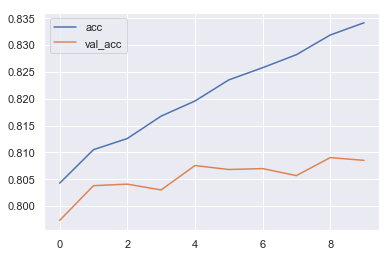

In [0]:
pd.DataFrame(history.history)[['acc','val_acc']].plot()

In [0]:
from sklearn.metrics import classification_report

labels = sorted(set([x[0] for x in y_true.tolist()]))
targets = encoder.inverse_transform(labels)

y_pred = classifier.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=targets))

                            precision    recall  f1-score   support

   Accounting & Consulting       0.72      0.53      0.61       286
             Admin Support       0.69      0.73      0.71      2063
          Customer Service       0.75      0.43      0.55       113
  Data Science & Analytics       0.51      0.23      0.32       274
         Design & Creative       0.89      0.84      0.87      3858
Engineering & Architecture       0.71      0.69      0.70       328
           IT & Networking       0.69      0.42      0.52       390
                     Legal       0.67      0.38      0.48        58
         Sales & Marketing       0.70      0.65      0.68      1211
               Translation       0.86      0.92      0.89       825
Web, Mobile & Software Dev       0.82      0.91      0.86      5387
                   Writing       0.85      0.84      0.84      2801

                 micro avg       0.81      0.81      0.81     17594
                 macro avg       0.74      0.6

In [0]:
new_data = data_subset_empty.sample(1000)['as_opening_title']

In [0]:
new_data.index = range(len(new_data))

In [0]:
new_X = []

for doc in nlp.pipe(new_data, n_threads=4, batch_size=10000):
    new_X.append(doc.vector)

new_X = np.vstack(new_X)

In [0]:
predictions = classifier.predict_classes(new_X)

In [0]:
result = pd.concat([new_data, pd.Series(predictions.tolist())], axis=1)

In [0]:
result['category'] = encoder.inverse_transform(result[0])

In [0]:
result['category'].unique()

array(['Admin Support', 'Writing', 'Design & Creative',
       'Web, Mobile & Software Dev', 'Translation', 'Sales & Marketing',
       'Legal', 'IT & Networking', 'Data Science & Analytics',
       'Accounting & Consulting', 'Engineering & Architecture',
       'Customer Service'], dtype=object)

In [0]:
result[result.category == 'Writing']

,as_opening_title,0,category
1,Retool an article,12,Writing
12,Do a Voiceover for a Fiverr sale script,12,Writing
28,Asian Cultural Studies and Identity,12,Writing
40,Writer for Unique Blog Posts,12,Writing
44,Short Descriptions,12,Writing
50,"Engaging, Resourceful Content Writer - HEALTHCARE",12,Writing
59,Discussions on Labor in Philippines,12,Writing
85,Hotel & Travel Articles - Native English - 5 S...,12,Writing
100,Editing Short Children Book,12,Writing
102,Quick Books Training,12,Writing
